## Los datos
- Grupo
- Sexo
- Edad
- Modo_Llegada
- Lesión
- Queja_Principal
- Estado_Mental
- Dolor
- Dolor_NRS
- SBP
- DBP
- HR
- RR
- BT
- Saturación
- KTAS_Enfermera
- Diagnóstico_Urgencias
- Disposición
- KTAS_Experto
- Grupo_Error
- Duración_Estancia_Min
- Duración_KTAS_Min
- Error_Triaje


In [1900]:
import numpy as np
import pandas as pd

from joblib import dump, load

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import scipy.stats as stats
import scipy.optimize as optimize
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

## 1. Carga de los datos

In [1901]:
datos = pd.read_csv("./data/Regresión_train_data.csv")

In [1902]:
datos.shape

(1000, 23)

In [1903]:
datos.dtypes

Grupo                         int64
Sexo                          int64
Edad                          int64
Modo_Llegada                  int64
Lesion                        int64
Queja_Principal              object
Estado_Mental                 int64
Dolor                         int64
dolor_NRS                    object
SBP                         float64
DBP                         float64
HR                          float64
RR                          float64
BT                          float64
Saturacion                  float64
KTAS_enfermera                int64
Diagnostico_En_Urgencias     object
Disposicion                   int64
KTAS_experto                  int64
Grupo_De_Error                int64
Duracion_Estancia_Min         int64
Duracion_KTAS_Min            object
Error_Triaje                  int64
dtype: object

In [1904]:
datos.sample(5)

,Grupo,Sexo,Edad,Modo_Llegada,Lesion,Queja_Principal,Estado_Mental,Dolor,dolor_NRS,SBP,...,BT,Saturacion,KTAS_enfermera,Diagnostico_En_Urgencias,Disposicion,KTAS_experto,Grupo_De_Error,Duracion_Estancia_Min,Duracion_KTAS_Min,Error_Triaje
708,1,2,53,1,1,Rt abd pain,1,1,4,115.0,...,36.3,NaN,4,Gallbladder cancer,1,4,0,272,"7,77",0
341,2,1,53,3,2,dizziness,1,0,#BOÞ!,130.0,...,36.1,97.0,2,"Ingested mushrooms, toxic effect of",2,2,0,522,"5,00",0
167,1,2,54,2,1,dizziness,1,1,5,143.0,...,36.0,NaN,3,Stroke,4,3,0,333,"6,25",0
540,1,1,33,3,1,"pain, low back",1,1,3,109.0,...,36.0,NaN,4,Back pain,1,4,0,68,"11,38",0
92,2,1,83,4,1,right hemiparesis,1,1,3,160.0,...,36.3,99.0,3,Cerebral infarction due to thrombosis of middl...,2,2,8,516,"5,00",2


## 2. Entendimiento de los datos

Variables numericas candidatas a utilizar

In [1905]:
candidatas = ["Grupo", "Lesion_stan","KTAS_experto_stan","EWS", "Dur_KTAS_lin"]
numericas = ["Grupo", "Sexo", "Sexo_stan", "Edad",  "Modo_Llegada", "Lesion", "Lesion_stan","Estado_Mental", "Dolor","dolor_NRS","KTAS_enfermera", "Disposicion", "KTAS_experto", "KTAS_experto_stan", "Duracion_KTAS_Min","Dur_KTAS_lin",  "Duracion_Estancia_Min"]
numericas2 = ["Grupo", "Sexo", "Sexo_stan", "Edad", "Modo_Llegada", "Lesion", "Lesion_stan","Estado_Mental", "Dolor","dolor_NRS","KTAS_enfermera", "Disposicion", "KTAS_experto", "KTAS_experto_stan", "Duracion_KTAS_Min"]


In [1906]:
datos.describe()

,Grupo,Sexo,Edad,Modo_Llegada,Lesion,Estado_Mental,Dolor,SBP,DBP,HR,RR,BT,Saturacion,KTAS_enfermera,Disposicion,KTAS_experto,Grupo_De_Error,Duracion_Estancia_Min,Error_Triaje
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.0000,1000.000000,1000.000000,983.000000,979.000000,988.000000,985.000000,989.000000,444.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,1.450000,1.514000,53.892000,2.811000,1.2000,1.103000,0.562000,133.485249,79.566905,84.400810,19.450761,36.562993,97.047297,3.328000,1.610000,3.260000,0.569000,12792.480000,0.253000
std,0.497743,0.500054,19.826483,0.796186,0.4002,0.431946,0.496389,27.156136,15.174593,16.297428,2.069882,0.519699,4.761112,0.862067,1.161572,0.865534,1.587375,87721.151446,0.630387
min,1.000000,1.000000,16.000000,1.000000,1.0000,1.000000,0.000000,50.000000,31.000000,32.000000,14.000000,35.000000,20.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,36.000000,2.000000,1.0000,1.000000,0.000000,114.000000,70.000000,73.000000,18.000000,36.200000,97.000000,3.000000,1.000000,3.000000,0.000000,132.750000,0.000000
50%,1.000000,2.000000,56.000000,3.000000,1.0000,1.000000,1.000000,130.000000,80.000000,82.000000,20.000000,36.500000,98.000000,3.000000,1.000000,3.000000,0.000000,270.500000,0.000000
75%,2.000000,2.000000,70.250000,3.000000,1.0000,1.000000,1.000000,150.000000,90.000000,96.000000,20.000000,36.800000,99.000000,4.000000,2.000000,4.000000,0.000000,620.000000,0.000000
max,2.000000,2.000000,94.000000,7.000000,2.0000,4.000000,1.000000,275.000000,160.000000,148.000000,30.000000,39.800000,100.000000,5.000000,7.000000,5.000000,9.000000,709510.000000,2.000000


In [1907]:
datos["Sexo"].value_counts()


Sexo
2    514
1    486
Name: count, dtype: int64

In [1908]:
datos[datos["Dolor"] != 0][datos["dolor_NRS"] == "#BOÞ!"]

C:\Users\cesar\AppData\Local\Temp\ipykernel_56640\2407576111.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  datos[datos["Dolor"] != 0][datos["dolor_NRS"] == "#BOÞ!"]


,Grupo,Sexo,Edad,Modo_Llegada,Lesion,Queja_Principal,Estado_Mental,Dolor,dolor_NRS,SBP,...,BT,Saturacion,KTAS_enfermera,Diagnostico_En_Urgencias,Disposicion,KTAS_experto,Grupo_De_Error,Duracion_Estancia_Min,Duracion_KTAS_Min,Error_Triaje
336,1,1,90,2,1,acute dyspnea,1,1,#BOÞ!,65.0,...,36.0,NaN,2,"Colon cancer, sigmoid",5,1,1,126,"9,58",2
951,1,2,81,2,2,right hip pain,1,1,#BOÞ!,90.0,...,36.0,NaN,3,Hip pain,2,3,0,649,"4,08",0


In [1909]:
datos["Dolor"].value_counts()

Dolor
1    562
0    438
Name: count, dtype: int64

In [1910]:
datos["dolor_NRS"].value_counts()

dolor_NRS
#BOÞ!    440
3        209
4        111
5        109
6         59
2         31
7         27
8          8
10         3
1          2
9          1
Name: count, dtype: int64

In [1911]:
datos["Modo_Llegada"].value_counts()

Modo_Llegada
3    588
2    220
4    122
1     60
6      7
5      2
7      1
Name: count, dtype: int64

In [1912]:
datos["Grupo_De_Error"].value_counts().sort_index()


Grupo_De_Error
0    851
1     16
2     39
3      6
4     50
5     11
6      6
7      7
8      9
9      5
Name: count, dtype: int64

In [1913]:
datos["Queja_Principal"].value_counts().sort_index()

Queja_Principal
??                       5
?? ??                    1
?? ???                   2
?? ??? ??                1
???                      3
                        ..
weakness                 1
whirling type vertigo    3
wrist laceration         1
wrist pain, Lt           1
wrist pain, Rt           1
Name: count, Length: 347, dtype: int64

In [1914]:
datos["KTAS_experto_stan"]=datos["KTAS_experto"].apply(lambda x: 5 if x==1 else( 4 if x==2 else(2 if x==4 else (1 if x==5 else(3)))))

In [1915]:
datos["Sexo_stan"] = datos["Sexo"].apply(lambda x: 0 if x == 2 else x)
datos["Sexo_stan"].value_counts()

Sexo_stan
0    514
1    486
Name: count, dtype: int64

In [1916]:
datos["Lesion_stan"]=datos["Lesion"].apply(lambda x:0 if x == 2 else x)
datos["Lesion_stan"].value_counts()

Lesion_stan
1    800
0    200
Name: count, dtype: int64

In [1917]:
def calida_dolor_NRS(registro):
    if registro["dolor_NRS"] == "#BOÞ!" and registro["Dolor"] == 0:
        return 0
    elif registro["dolor_NRS"] == "#BOÞ!" and registro["Dolor"] != 0:
        return registro["dolor_NRS"]
    return int(registro["dolor_NRS"])
datos['dolor_NRS'] = datos.apply(calida_dolor_NRS, axis=1)

mean = datos[datos["dolor_NRS"] != "#BOÞ!" ]['dolor_NRS'].mean()
datos["dolor_NRS"] = datos["dolor_NRS"].apply(lambda x: round(mean) if x == "#BOÞ!" else x)
datos["dolor_NRS"].value_counts()


dolor_NRS
0     438
3     209
4     111
5     109
6      59
2      33
7      27
8       8
10      3
1       2
9       1
Name: count, dtype: int64

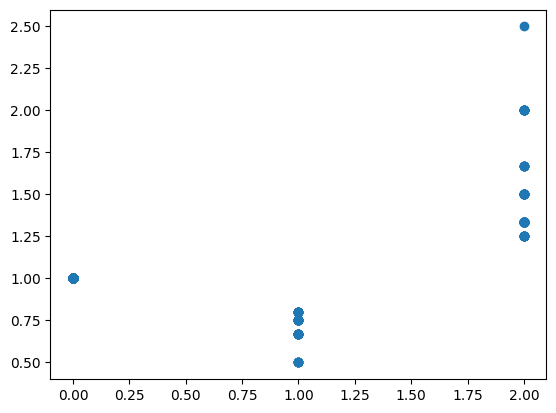

In [1918]:
datos[["KTAS_enfermera","KTAS_experto","Error_Triaje"]]
a = datos[datos["KTAS_enfermera"]!=datos["KTAS_experto"]][["KTAS_enfermera","KTAS_experto","Error_Triaje"]]
a[a["Error_Triaje"]==1]
plt.scatter(datos["Error_Triaje"], datos["KTAS_enfermera"]/datos["KTAS_experto"])


In [1919]:
def calcularEWS(registro):
    total = 0
    
    # Frecuencia respiratoria (RR)
    if registro['RR'] <= 8:
        total += 2
    elif 9 <= registro['RR'] <= 14:
        total += 0
    elif 15 <= registro['RR'] <= 20:
        total += 1
    elif 21 <= registro['RR'] <= 29:
        total += 2
    elif registro['RR'] >= 30:
        total += 3
    
    # Presión arterial sistólica (SBP)
    if registro['SBP'] <= 70:
        total += 3
    elif 71 <= registro['SBP'] <= 80:
        total += 2
    elif 81 <= registro['SBP'] <= 100:
        total += 1
    elif 101 <= registro['SBP'] <= 199:
        total += 0
    elif registro['SBP'] >= 200:
        total += 2

    # Frecuencia cardíaca (HR)
    if registro['HR'] <= 40:
        total += 2
    elif 41 <= registro['HR'] <= 50:
        total += 1
    elif 51 <= registro['HR'] <= 100:
        total += 0
    elif 101 <= registro['HR'] <= 110:
        total += 1
    elif 111 <= registro['HR'] <= 129:
        total += 2
    elif registro['HR'] >= 130:
        total += 3

    # Temperatura corporal (BT)
    if registro['BT'] < 35.0:
        total += 2
    elif 35.0 <= registro['BT'] <= 38.4:
        total += 0
    elif 38.5 <= registro['BT']:
        total += 2

    # Saturación de oxígeno (Saturacion)
    if registro['Saturacion'] <= 91:
        total += 3
    elif 92 <= registro['Saturacion'] <= 93:
        total += 2
    elif 94 <= registro['Saturacion'] <= 95:
        total += 1

    # Nivel de conciencia
    if registro['Estado_Mental'] == 1:
        total += 0
    elif registro['Estado_Mental'] == 2:
        total += 1
    elif registro['Estado_Mental'] == 3:
        total += 2
    elif registro['Estado_Mental'] == 4:
        total += 3
    return total

datos['EWS'] = datos.apply(calcularEWS, axis=1)
datos.head()

,Grupo,Sexo,Edad,Modo_Llegada,Lesion,Queja_Principal,Estado_Mental,Dolor,dolor_NRS,SBP,...,Disposicion,KTAS_experto,Grupo_De_Error,Duracion_Estancia_Min,Duracion_KTAS_Min,Error_Triaje,KTAS_experto_stan,Sexo_stan,Lesion_stan,EWS
0,2,2,49,2,1,ant. chest pain,1,1,2,150.0,...,2,2,0,1591,"2,00",0,4,0,1,1
1,2,2,30,4,1,headache,1,1,4,140.0,...,7,3,0,211,"3,00",0,3,0,1,1
2,2,1,61,3,2,ant. chest pain,1,1,3,100.0,...,1,4,0,119,"2,00",0,2,1,0,2
3,2,2,61,3,1,headache,1,1,4,120.0,...,1,3,4,414,"2,00",2,3,0,1,1
4,1,2,67,3,1,fever & chill,1,0,0,143.0,...,1,2,1,267,"3,60",2,4,0,1,4


In [1920]:
datos.sample(10)

,Grupo,Sexo,Edad,Modo_Llegada,Lesion,Queja_Principal,Estado_Mental,Dolor,dolor_NRS,SBP,...,Disposicion,KTAS_experto,Grupo_De_Error,Duracion_Estancia_Min,Duracion_KTAS_Min,Error_Triaje,KTAS_experto_stan,Sexo_stan,Lesion_stan,EWS
879,2,1,77,3,1,dyspnea,1,0,0,100.0,...,2,3,0,10118,"3,00",0,3,1,1,4
915,2,1,28,3,1,Vaginal Bleeding,1,0,0,100.0,...,1,3,0,375,"5,00",0,3,1,1,3
497,1,2,23,3,2,Finger Injury,1,1,6,159.0,...,2,4,0,333,"5,95",0,2,0,0,2
481,1,1,55,3,1,syncope,1,0,0,134.0,...,1,3,0,120,"6,95",0,3,1,1,1
732,2,1,55,4,2,post neck pain,1,1,4,130.0,...,2,2,0,399,"3,00",0,4,1,0,1
27,2,2,44,3,1,dyspnea,1,1,3,130.0,...,1,3,0,9891,"3,00",0,3,0,1,2
208,1,1,81,4,1,sezure like motion,1,0,0,NaN,...,1,3,0,982,"8,98",0,3,1,1,4
926,2,2,21,3,1,dyspnea,1,0,0,130.0,...,2,3,0,625,"3,00",0,3,0,1,4
281,1,1,64,3,1,fever,1,1,3,180.0,...,1,4,0,361,"4,18",0,2,1,1,1
956,1,1,74,2,1,Seizure Like Activity,1,0,0,161.0,...,1,3,0,173,"4,28",0,3,1,1,0


Análisis de completitud

In [1921]:
datos.isnull().sum() / datos.shape[0]

Grupo                       0.000
Sexo                        0.000
Edad                        0.000
Modo_Llegada                0.000
Lesion                      0.000
Queja_Principal             0.000
Estado_Mental               0.000
Dolor                       0.000
dolor_NRS                   0.000
SBP                         0.017
DBP                         0.021
HR                          0.012
RR                          0.015
BT                          0.011
Saturacion                  0.556
KTAS_enfermera              0.000
Diagnostico_En_Urgencias    0.001
Disposicion                 0.000
KTAS_experto                0.000
Grupo_De_Error              0.000
Duracion_Estancia_Min       0.000
Duracion_KTAS_Min           0.000
Error_Triaje                0.000
KTAS_experto_stan           0.000
Sexo_stan                   0.000
Lesion_stan                 0.000
EWS                         0.000
dtype: float64

### 2.1. Búsqueda de relaciones con la variable objetivo

Si se logra visualizar o cuantificar altas correlaciones entre las variables de entrada y la variable objetivo, se podrán soportar las decisiones del experto con base en la evidencia.

In [1922]:
datos["Duracion_KTAS_Min"] = datos["Duracion_KTAS_Min"].str.replace(',', '.').astype('float64')
datos["Dur_KTAS_lin"]=np.log(datos["Duracion_KTAS_Min"])

In [1923]:
'''for variable in datos[numericas]:
    sns.pairplot(datos.sample(frac=0.2), height=3, y_vars="Duracion_Estancia_Min", x_vars=variable, kind="scatter")'''

'for variable in datos[numericas]:\n    sns.pairplot(datos.sample(frac=0.2), height=3, y_vars="Duracion_Estancia_Min", x_vars=variable, kind="scatter")'

In [1924]:
datos["Modo_Llegada"] = datos["Modo_Llegada"].apply(lambda x: 1 if x == 1 else (2 if x == 2 or x ==4 else (3 if x == 3 else 4)))


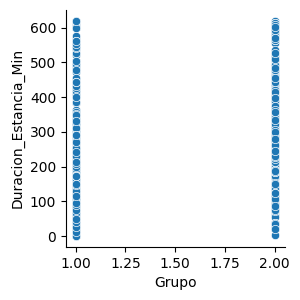

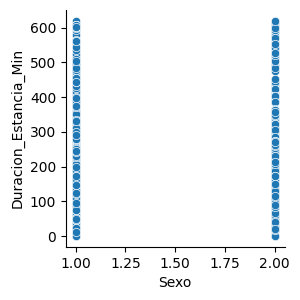

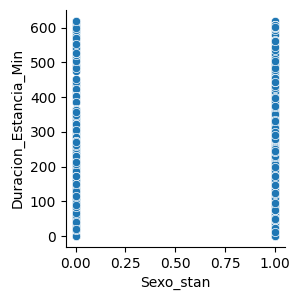

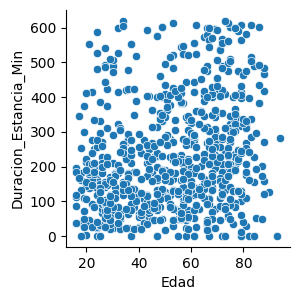

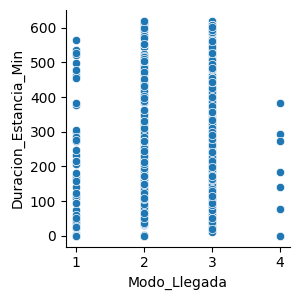

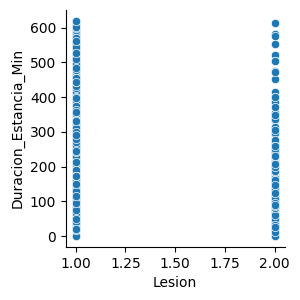

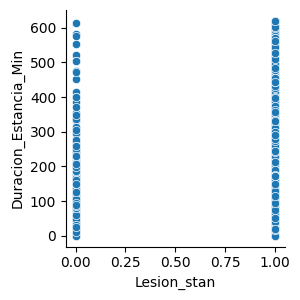

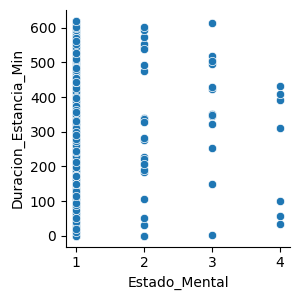

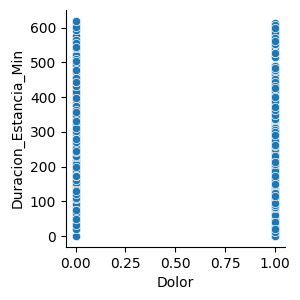

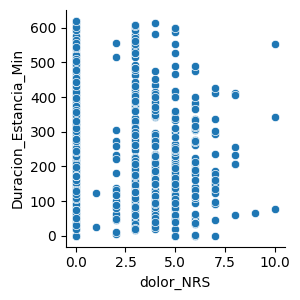

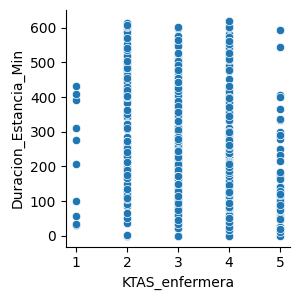

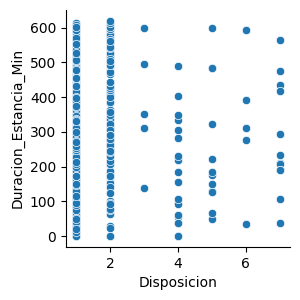

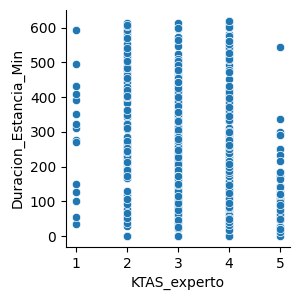

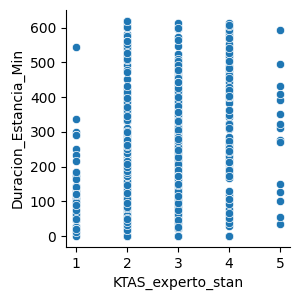

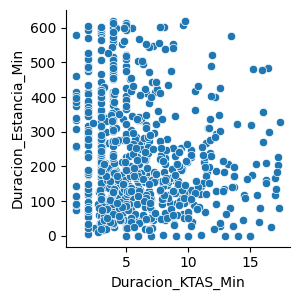

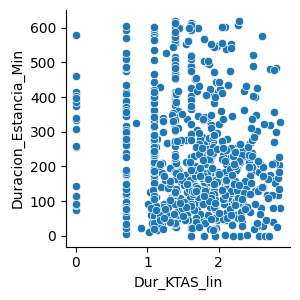

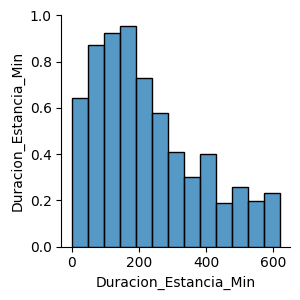

In [1925]:
val = datos["Duracion_Estancia_Min"].quantile(0.75)
prueba=datos[datos["Duracion_Estancia_Min"]<=val]
for variable in numericas:
    sns.pairplot(prueba, height=3, y_vars="Duracion_Estancia_Min", x_vars=variable, kind="scatter")

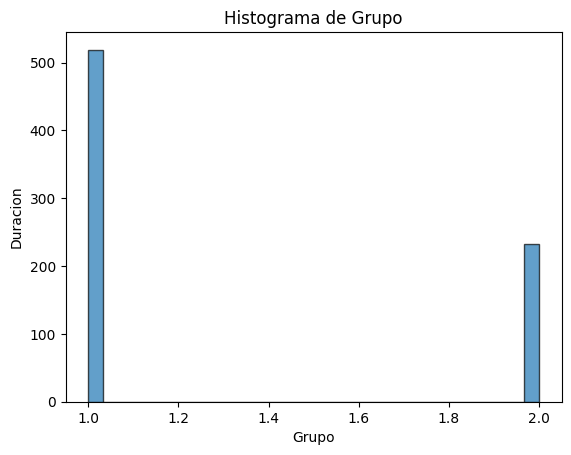

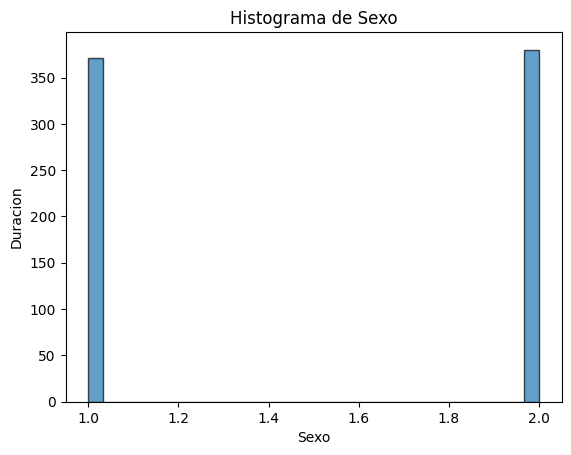

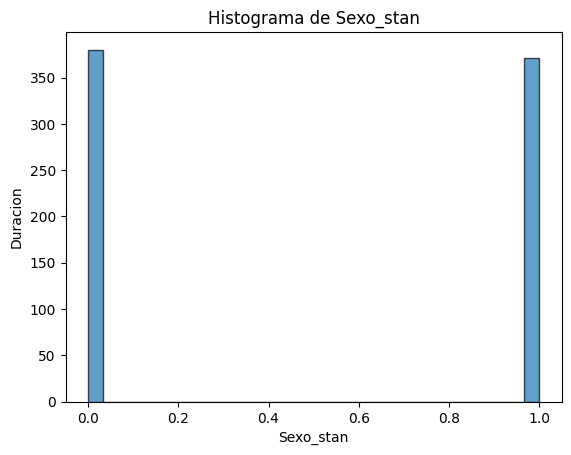

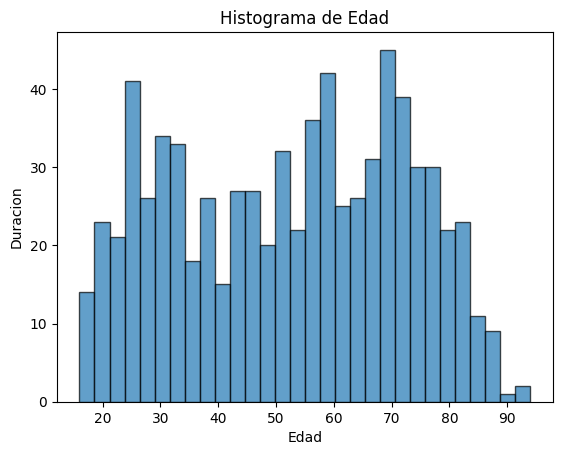

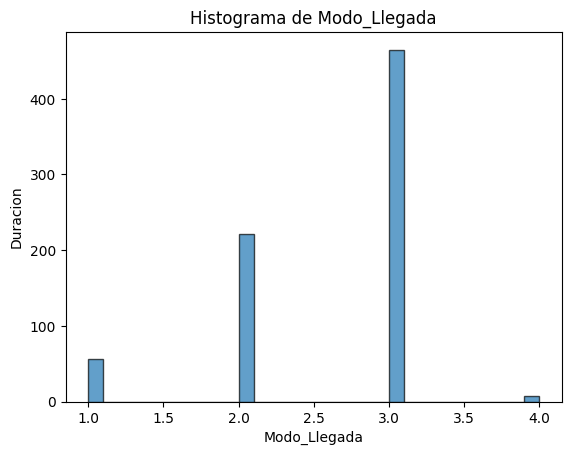

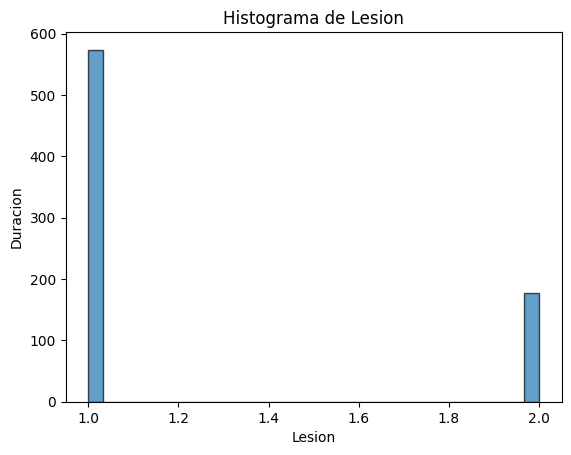

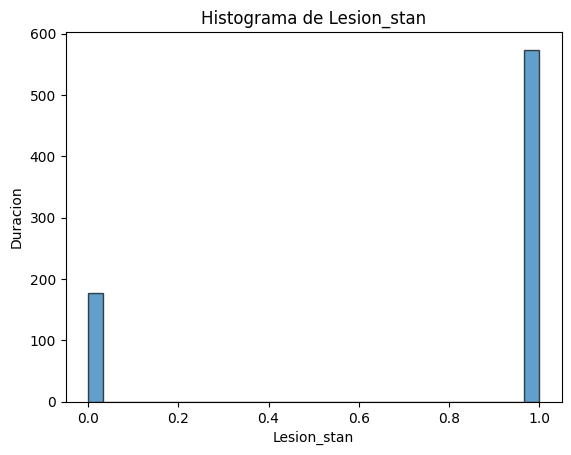

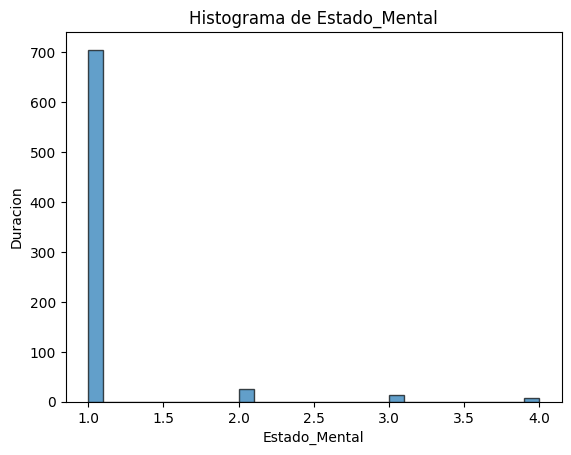

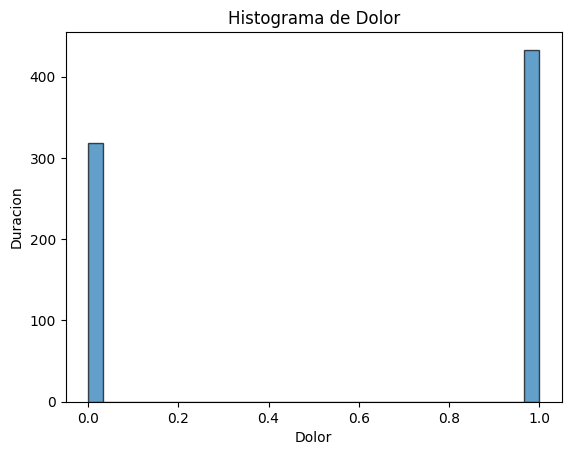

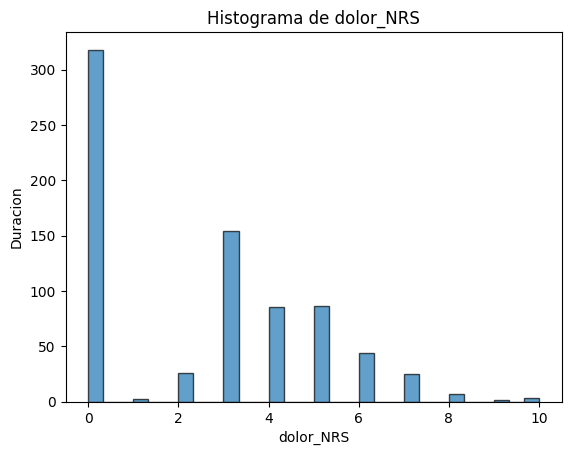

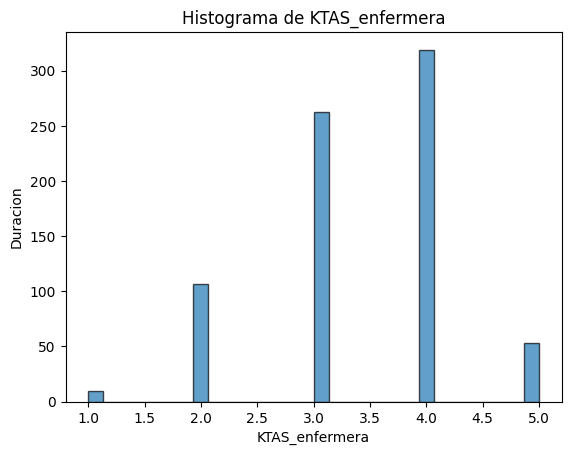

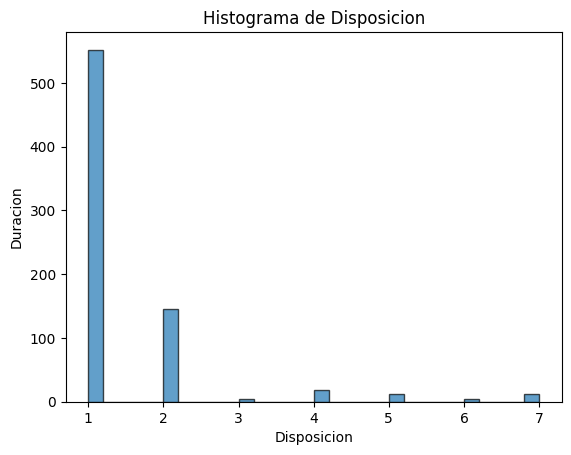

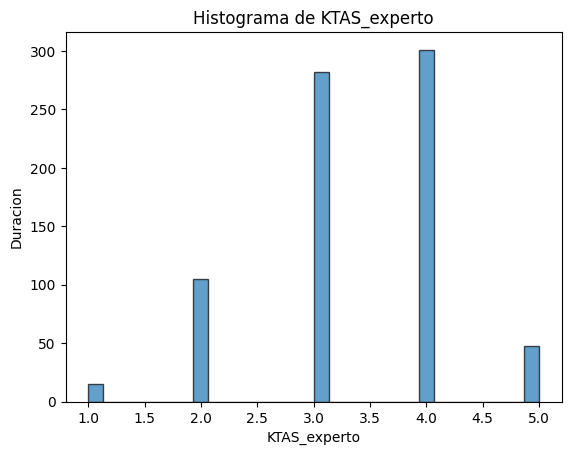

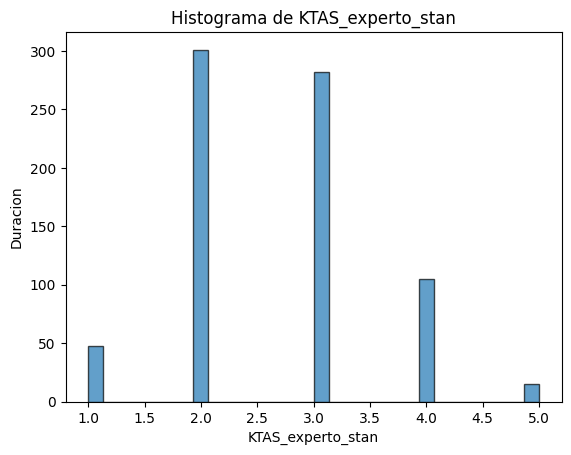

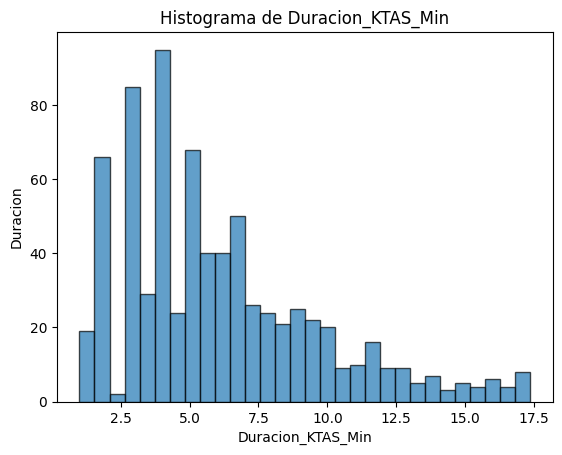

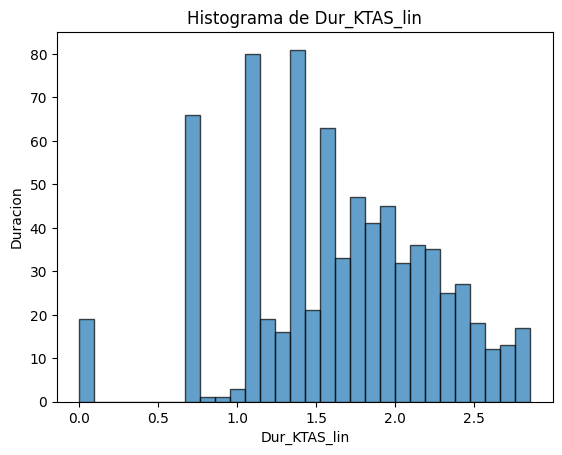

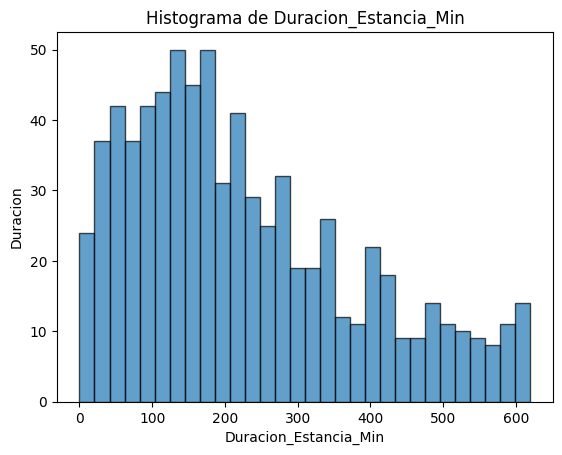

In [1926]:
for variable in numericas:
    plt.hist(prueba[variable], bins=30, edgecolor='k', alpha=0.7)
    plt.title('Histograma de ' + variable)
    plt.xlabel(variable)
    plt.ylabel('Duracion')
    plt.show()

C:\Users\cesar\AppData\Roaming\Python\Python310\site-packages\scipy\optimize\_numdiff.py:592: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0


Parámetros ajustados: n=5.0, p=0.5


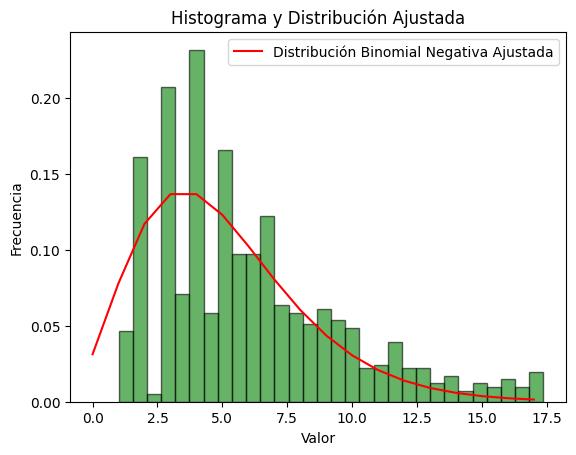

In [1927]:
# Definir la función de log-verosimilitud
def negative_binomial_log_likelihood(params, data):
    n, p = params
    return -np.sum(stats.nbinom.logpmf(data, n, p))

# Estimar parámetros usando scipy.optimize
initial_guess = [5, 0.5]  # Valores iniciales para n y p
result = optimize.minimize(negative_binomial_log_likelihood, initial_guess, args=(prueba["Duracion_KTAS_Min"],), bounds=[(1, None), (0.01, 0.99)])

n_est, p_est = result.x
print(f"Parámetros ajustados: n={n_est}, p={p_est}")

# Graficar los datos y la distribución ajustada
x = np.arange(0, prueba["Duracion_KTAS_Min"].max())
pdf_fitted = stats.nbinom.pmf(x, n_est, p_est)


plt.hist(prueba["Duracion_KTAS_Min"], bins=30, density=True, alpha=0.6, color='g', edgecolor='black')
plt.plot(x, pdf_fitted, 'r-', label='Distribución Binomial Negativa Ajustada')
plt.title('Histograma y Distribución Ajustada')
plt.xlabel('Valor')
plt.ylabel('Frecuencia')
plt.legend()
plt.show()

Parámetros ajustados: shape=0.6045446465501697, loc=0, scale=5.156225969123075


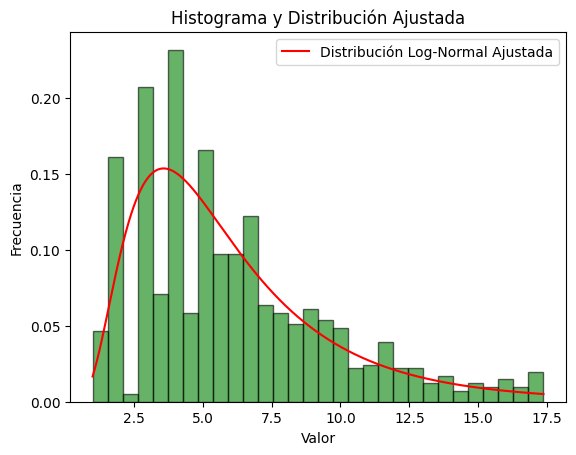

In [1928]:
shape, loc, scale = stats.lognorm.fit(prueba["Duracion_KTAS_Min"], floc=0)

print(f"Parámetros ajustados: shape={shape}, loc={loc}, scale={scale}")

# Graficar el histograma de los datos y la distribución ajustada
x = np.linspace(min(prueba["Duracion_KTAS_Min"]), max(prueba["Duracion_KTAS_Min"]), prueba["Duracion_KTAS_Min"].shape[0])
pdf_fitted = stats.lognorm.pdf(x, shape, loc, scale)

plt.hist(prueba["Duracion_KTAS_Min"], bins=30, density=True, alpha=0.6, color='g', edgecolor='black')
plt.plot(x, pdf_fitted, 'r-', label='Distribución Log-Normal Ajustada')
plt.title('Histograma y Distribución Ajustada')
plt.xlabel('Valor')
plt.ylabel('Frecuencia')
plt.legend()
plt.show()

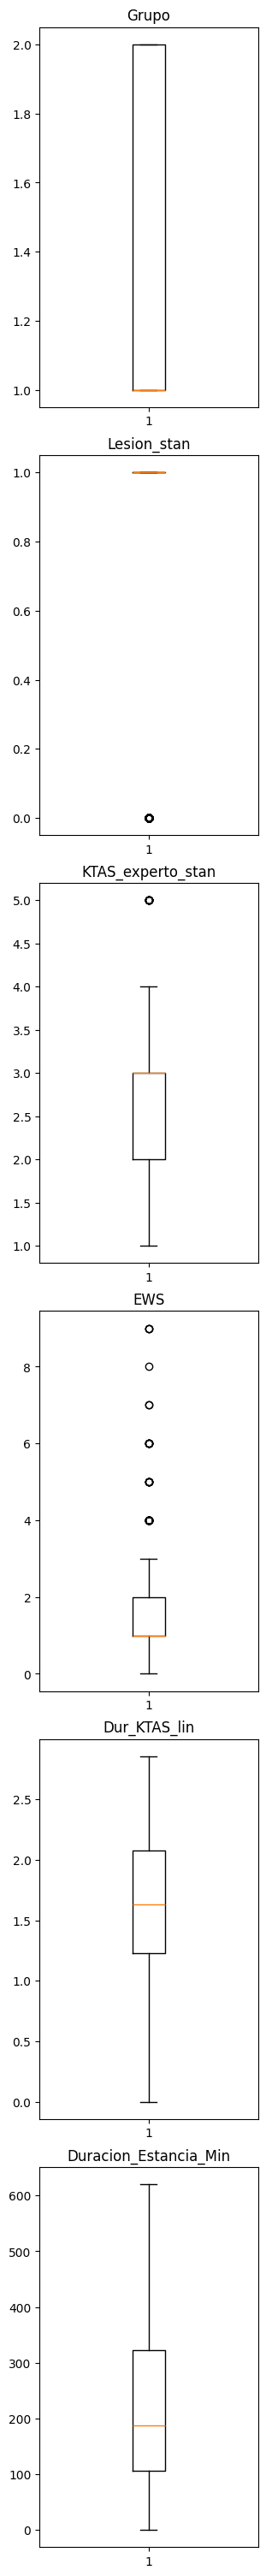

In [1929]:
candidatas2=candidatas+["Duracion_Estancia_Min"]
fig, ax = plt.subplots(len(candidatas2), 1, layout="constrained", figsize=(3,30))
for i in range(len(candidatas2)):
    ax[i].boxplot(prueba[candidatas2[i]])
    ax[i].set_title(candidatas2[i])

<Axes: ylabel='Duracion_Estancia_Min'>

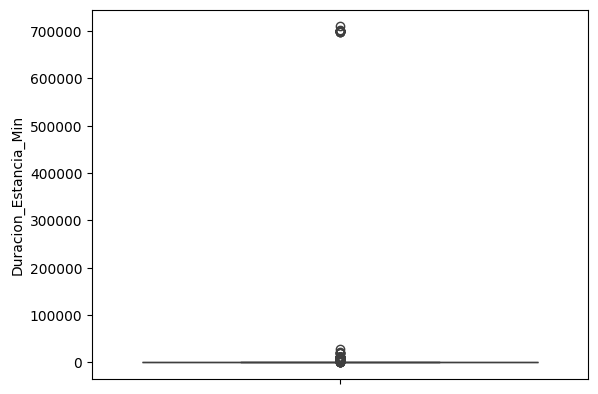

In [1930]:
sns.boxplot(datos["Duracion_Estancia_Min"])


(array([4.15638962e-05, 4.22827021e-08, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 6.76523234e-07]),
 array([     0.        ,  23650.33333333,  47300.66666667,  70951.        ,
         94601.33333333, 118251.66666667, 141902.        , 165552.33333333,
        189202.66666667, 212853.        , 236503.33333333, 260153.66666667,
        283804.        , 307454.33333333, 331104.66666667, 354755.        ,
        378405.33333333, 402055.66666667, 425706.        , 449356.33333333,
        473006.66666667, 496657.        , 520307.33333333, 543957.66666667

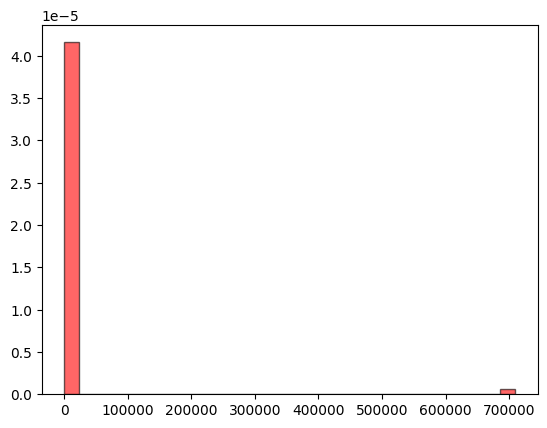

In [1931]:
plt.hist(datos["Duracion_Estancia_Min"], bins=30, density=True, alpha=0.6, color='r', edgecolor='black')


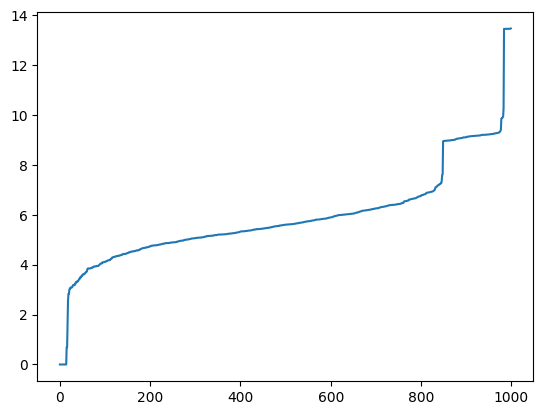

In [1932]:
plt.plot(np.log(np.sort(datos["Duracion_Estancia_Min"]+1)))

(751, 28)

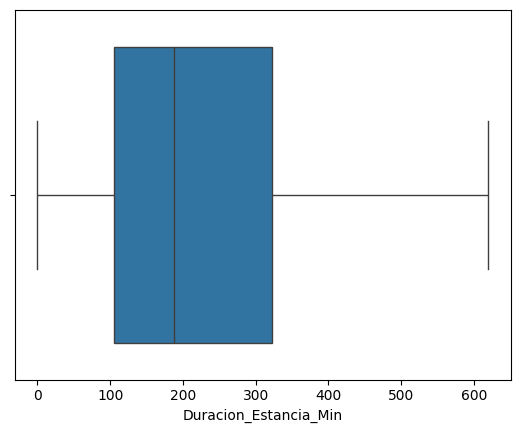

In [1933]:

sns.boxplot(prueba, x="Duracion_Estancia_Min")
prueba.shape

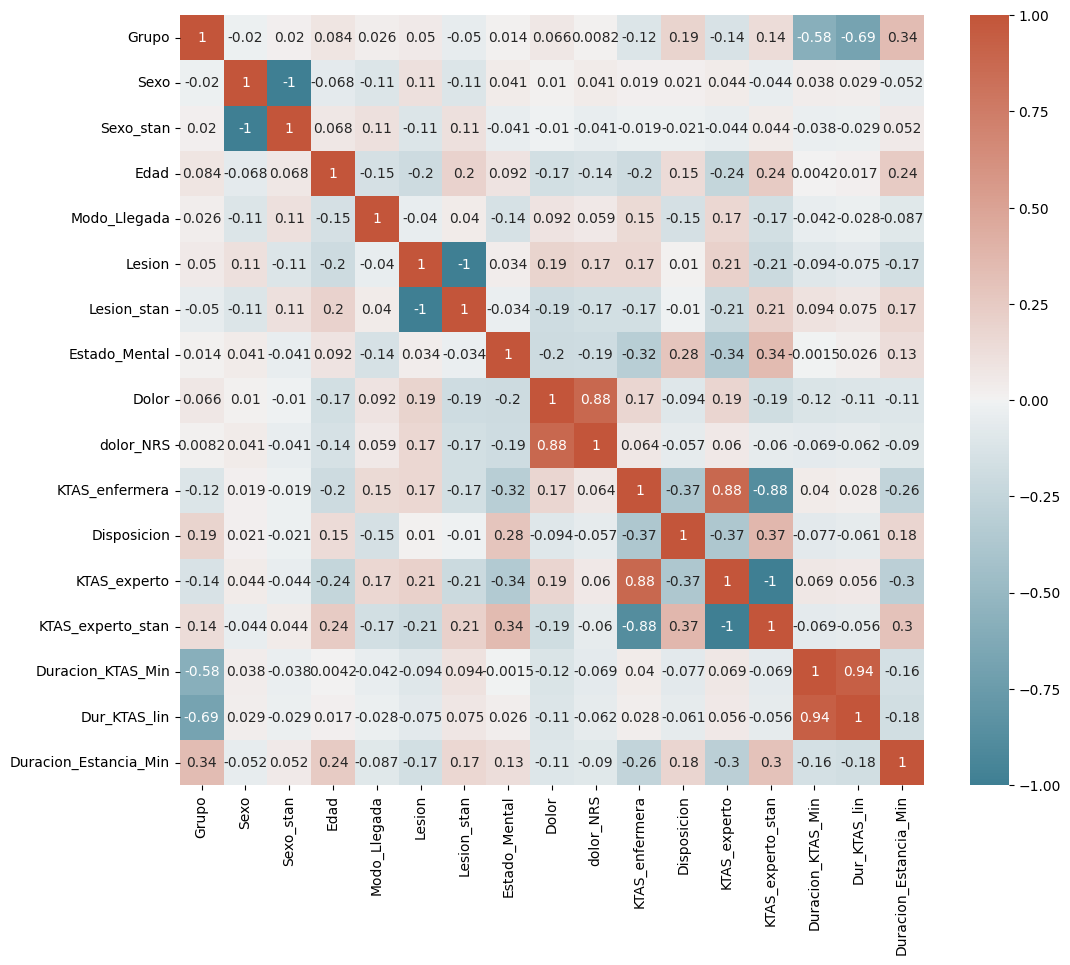

In [1934]:
plt.figure(figsize=(12, 10))
# Crear una paleta de colores divergente con el color blanco en el centro
cmap = sns.diverging_palette(220, 20, as_cmap=True)

# Crear el heatmap con la paleta personalizada
sns.heatmap(
    prueba[numericas].corr(),
    cmap=cmap,
    vmin=-1, vmax=1,
    annot=True
)

plt.show()

### 2.2. Búsqueda de relaciones entre las variables de entrada

**Importante:** La regresión lineal asume que sus variables de entrada no se encuentran altamente correlacionados.

<Axes: >

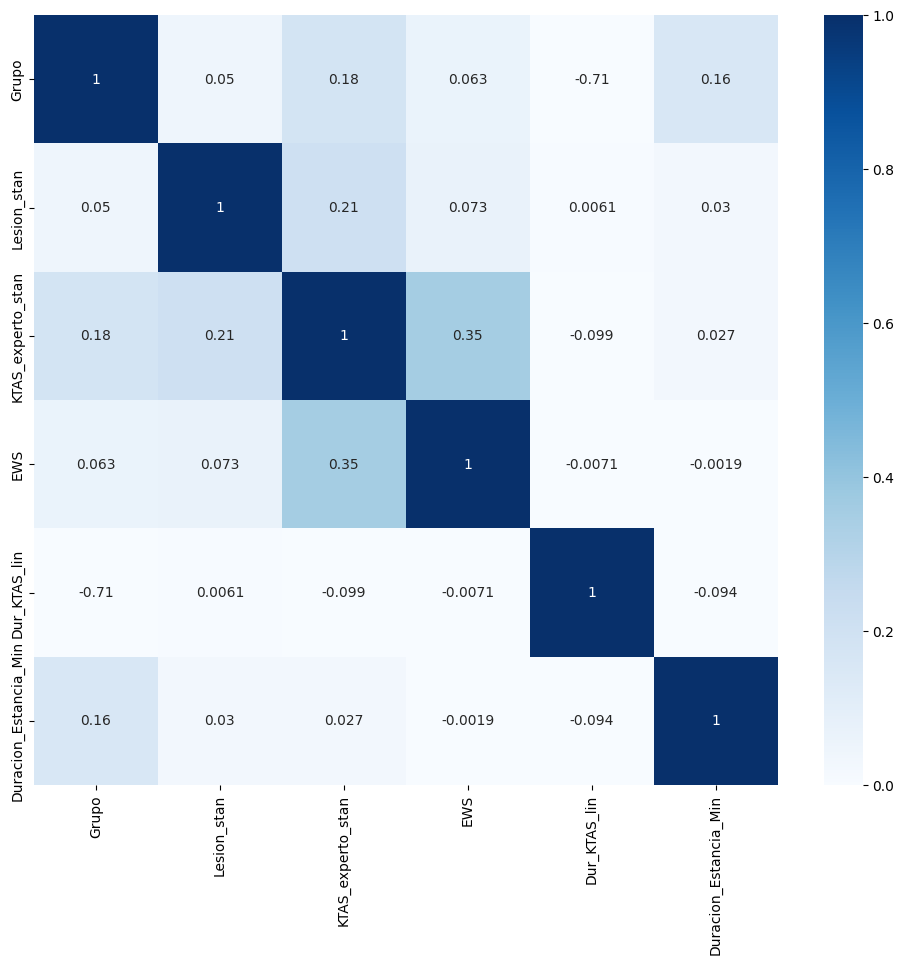

In [1935]:
plt.figure(figsize=(12, 10))
sns.heatmap(datos[candidatas+['Duracion_Estancia_Min']].corr(), cmap="Blues", vmin=0, vmax=1, annot = True)

## 3. Preparación de datos

### 3.1. Relacionado con la calidad de los datos

In [1936]:
val = datos["Duracion_Estancia_Min"].quantile(0.75)
datos=datos[datos["Duracion_Estancia_Min"]<=val]
print(val)
datos.shape


620.0


(751, 28)

In [1937]:
# Se eliminan los registros totalmente duplicados
datos = datos.dropna(subset=["Duracion_Estancia_Min"]+candidatas)

In [1938]:
datos.shape
total_rows = datos.shape[0]
total_rows

751

In [1939]:
datos[["Duracion_Estancia_Min"]+candidatas].isnull().sum() / datos.shape[0]

Duracion_Estancia_Min    0.0
Grupo                    0.0
Lesion_stan              0.0
KTAS_experto_stan        0.0
EWS                      0.0
Dur_KTAS_lin             0.0
dtype: float64

In [1940]:
datos[datos[["Duracion_Estancia_Min"]+candidatas] == '#BOÞ!'][["Duracion_Estancia_Min"]+candidatas].count()/ datos.shape[0]

Duracion_Estancia_Min    0.0
Grupo                    0.0
Lesion_stan              0.0
KTAS_experto_stan        0.0
EWS                      0.0
Dur_KTAS_lin             0.0
dtype: float64

In [1941]:
datos.loc[datos.duplicated(subset=candidatas, keep=False)].head(5)

,Grupo,Sexo,Edad,Modo_Llegada,Lesion,Queja_Principal,Estado_Mental,Dolor,dolor_NRS,SBP,...,KTAS_experto,Grupo_De_Error,Duracion_Estancia_Min,Duracion_KTAS_Min,Error_Triaje,KTAS_experto_stan,Sexo_stan,Lesion_stan,EWS,Dur_KTAS_lin
1,2,2,30,2,1,headache,1,1,4,140.0,...,3,0,211,3.0,0,3,0,1,1,1.098612
2,2,1,61,3,2,ant. chest pain,1,1,3,100.0,...,4,0,119,2.0,0,2,1,0,2,0.693147
3,2,2,61,3,1,headache,1,1,4,120.0,...,3,4,414,2.0,2,3,0,1,1,0.693147
9,2,2,27,2,1,LLQ pain,1,1,3,130.0,...,4,0,493,2.0,0,2,0,1,1,0.693147
12,2,2,69,3,1,dyspnea,1,0,0,100.0,...,3,0,415,4.0,0,3,0,1,2,1.386294


In [1942]:
duplicated_rows = datos.loc[datos.duplicated(subset=candidatas, keep=False)].shape[0]
duplicated_rows

295

In [1943]:
print(f"Duplicates: {(duplicated_rows/total_rows)*100:.4f}%")

Duplicates: 39.2810%


In [1944]:
datos.loc[datos.duplicated(subset=candidatas+["Duracion_Estancia_Min"], keep=False)].tail(4)

,Grupo,Sexo,Edad,Modo_Llegada,Lesion,Queja_Principal,Estado_Mental,Dolor,dolor_NRS,SBP,...,KTAS_experto,Grupo_De_Error,Duracion_Estancia_Min,Duracion_KTAS_Min,Error_Triaje,KTAS_experto_stan,Sexo_stan,Lesion_stan,EWS,Dur_KTAS_lin
996,1,1,27,3,1,Suicidal Attempt,1,0,0,110.0,...,3,0,442,7.42,0,3,1,1,1,2.004179
997,1,2,54,2,1,"pain, chest",1,1,6,159.0,...,2,0,214,4.95,0,4,0,1,1,1.599388
998,1,1,19,3,1,eye discomfort,1,0,0,132.0,...,4,0,50,3.45,0,2,1,1,1,1.238374
999,1,2,29,3,1,"pain, abdominal",1,1,6,137.0,...,3,0,116,5.97,0,3,0,1,1,1.786747


In [1945]:
duplicated_rows = datos.loc[datos.duplicated(subset=candidatas+["Duracion_Estancia_Min"], keep=False)].shape[0]
duplicated_rows

63

In [1946]:
print(f"Duplicates: {(duplicated_rows/total_rows)*100:.4f}%")

Duplicates: 8.3888%


In [1947]:
datos.drop_duplicates(subset=candidatas, inplace=True)
datos.drop_duplicates(subset=candidatas+["Duracion_Estancia_Min"], inplace=True)

In [1948]:
datos.shape

(543, 28)

Train: 142.37727523589766
Test: 132.14368275061634


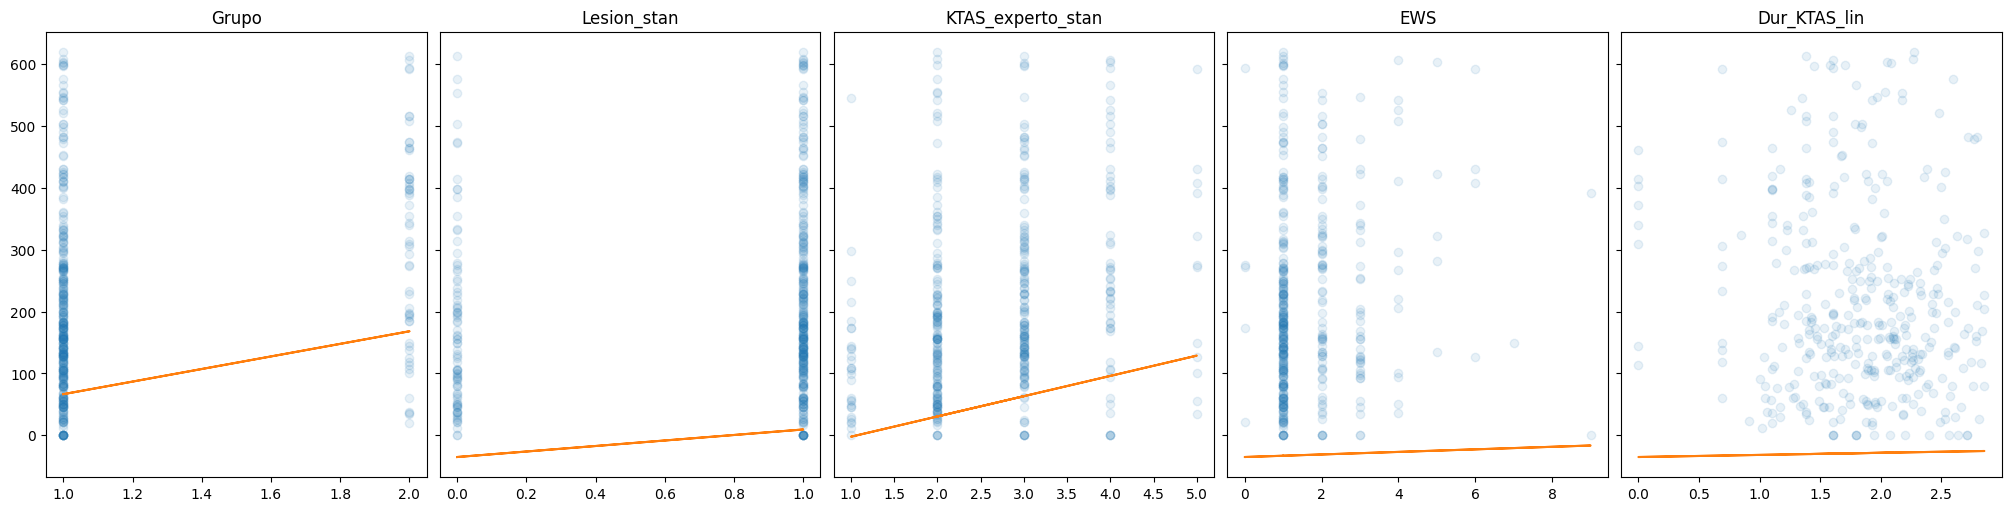

In [1949]:
X_train, X_test, y_train, y_test = train_test_split(datos[candidatas], datos["Duracion_Estancia_Min"], test_size=0.3, random_state=1)
X_train.shape, y_train.shape
X_test.shape, y_test.shape
regression = LinearRegression()
regression.fit(X_train, y_train)
pd.DataFrame({"columns": candidatas, "coef": regression.coef_})
f, axs = plt.subplots(1, len(candidatas), sharey=True, figsize=(20, 5), layout="constrained")

for i in range(len(candidatas)):
    col = candidatas[i]
    x = X_train[col]
    m = regression.coef_[i]
    b = regression.intercept_

    axs[i].plot(x, y_train, "o", alpha=0.1)
    axs[i].plot(x, x * m + b)
    axs[i].set_title(col)
print("Train:", np.sqrt(mean_squared_error(y_train, regression.predict(X_train))))
print("Test:", np.sqrt(mean_squared_error(y_test, regression.predict(X_test))))


In [1950]:
pd.DataFrame({"columns": candidatas, "coef": regression.coef_})

,columns,coef
0,Grupo,101.675944
1,Lesion_stan,44.533993
2,KTAS_experto_stan,32.802483
3,EWS,2.067761
4,Dur_KTAS_lin,3.414286


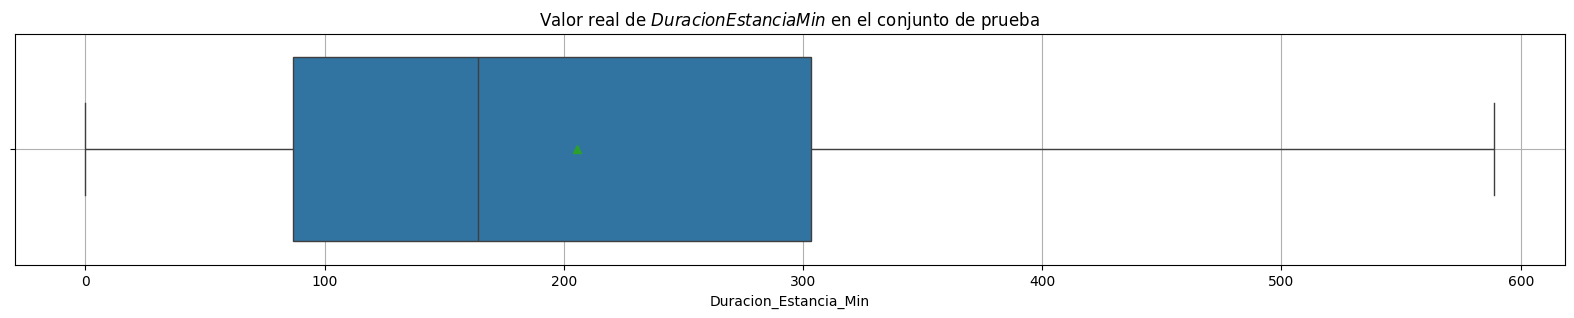

In [1951]:
plt.figure(figsize=(20, 3))
sns.boxplot(x=y_test, showmeans=True, orient="h")
plt.title("Valor real de $\t{Duracion Estancia Min}$ en el conjunto de prueba")
plt.grid()
plt.show()

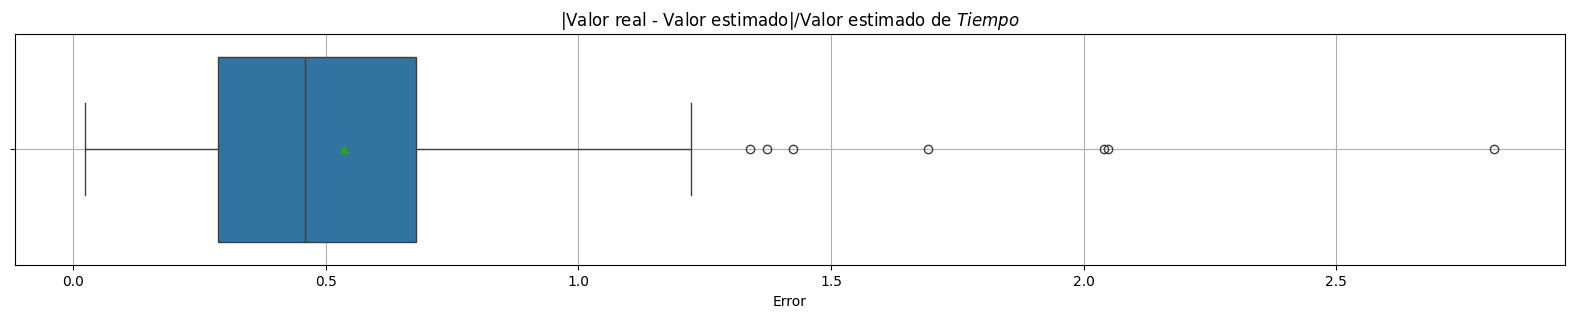

In [1952]:
plt.figure(figsize=(20, 3))
sns.boxplot(x=abs(y_test - regression.predict(X_test))/regression.predict(X_test), showmeans=True, orient="h")
plt.title("|Valor real - Valor estimado|/Valor estimado de $\t{Tiempo}$")
plt.xlabel("Error")
plt.grid()
plt.show()